In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np


import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

2022-10-31 20:49:27.412661: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 20:49:31.684256: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jazhiel/Root/root/lib
2022-10-31 20:49:31.684301: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-31 20:49:32.066463: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-31 20:49:40.02

In [2]:
#hmf = pd.read_csv('/home/jazhiel/ML_Notebooks/Datasets/HMF_fit.csv')
#hmf = hmf.drop(['Unnamed: 0'], axis=1)
#dataset_1 = hmf.copy()
#dataset_1


hmf_new = pd.read_csv('/home/jazhiel/ML_Notebooks/Datasets/HMF_theor.csv')
hmf_new = hmf_new.drop(['Unnamed: 0'], axis=1)

dataset = hmf_new.copy()


x = dataset['log_10(mvir)'].values
y = dataset['n(>M)'].values



In [3]:
dataset

,log_10(mvir),n(>M)
0,1.000000e+10,2.543783e-01
1,1.122018e+10,2.298566e-01
2,1.258925e+10,2.077056e-01
3,1.412538e+10,1.876949e-01
4,1.584893e+10,1.696162e-01
...,...,...
95,5.623413e+14,1.997294e-06
96,6.309573e+14,1.556080e-06
97,7.079458e+14,1.199768e-06
98,7.943282e+14,9.146886e-07


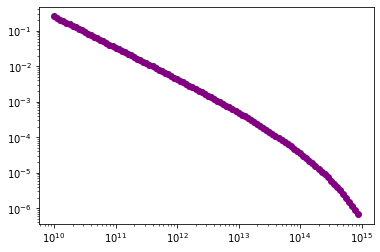

In [4]:
plt.yscale('log')
plt.xscale('log')

plt.scatter(hmf_new['log_10(mvir)'], hmf_new['n(>M)'], c = 'purple')

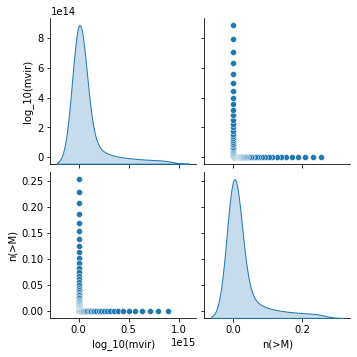

In [5]:
sns.pairplot(dataset, diag_kind="kde")

# plt.savefig("DistHD.png")



In [6]:
randomize = np.random.permutation(len(dataset.values))
data = dataset.values[randomize]

# Define a size for your train set 
split = 0.8
ntrain = int(split * len(data))
indx = [ntrain]
train_set, test_set = np.split(data, indx)

split = 0.5
ntrain = int(split * len(test_set))
indx = [ntrain]
validation_set, test_test = np.split(test_set, indx)

In [7]:
X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_val = validation_set[:, :-1]
y_val = validation_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [8]:
print(X_test.shape)
print(y_test.shape)

(20, 1)
(20,)


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

xscaler = StandardScaler()
#xscaler =   MinMaxScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
xscaler.fit(X_train)
# apply transform
X_train = xscaler.transform(X_train)
X_val = xscaler.transform(X_val)
X_test = xscaler.transform(X_test)

In [10]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]

In [402]:
def ann_model(ninput=1, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu',input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=optimizers.Adam(lr=1e-3),#RMSprop(lr=0.001),
                        loss='mae',
                        metrics=['mae', 'mse'])


#     test1_model.summary()
    return model

In [403]:
# dropout = grid_result.best_params_['dropout']
dropout = 0.3
# n_nodes1 = grid_result.best_params_['n_nodes1']
n_nodes1 = 100
# n_nodes2 = grid_result.best_params_['n_nodes2']
n_nodes2 = 200
# n_nodes3 = grid_result.best_params_['n_nodes3']
n_nodes3 = 150

In [404]:
neural_model = ann_model(n_nodes1=n_nodes1, n_nodes2=n_nodes2, n_nodes3=n_nodes3,
                        dropout=dropout)

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=100, 
                                         restore_best_weights=True)

lrdecay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               patience=2)
callbacks = [estop, lrdecay]

neural_model_history = neural_model.fit(X_train,
                                      y_train,
                                      epochs=120,
                                      batch_size=5,
                                      validation_data=(X_val,y_val),
                                      verbose=1)#, #callbacks=callbacks)



Epoch 1/120


/home/jazhiel/anaconda3/envs/yt-env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


16/16 [==============================] - 0s 9ms/step - loss: 0.0640 - mae: 0.0640 - mse: 0.0138 - val_loss: 0.0574 - val_mae: 0.0574 - val_mse: 0.0053
Epoch 2/120
16/16 [==============================] - 0s 3ms/step - loss: 0.0531 - mae: 0.0531 - mse: 0.0100 - val_loss: 0.0631 - val_mae: 0.0631 - val_mse: 0.0072
Epoch 3/120
16/16 [==============================] - 0s 3ms/step - loss: 0.0499 - mae: 0.0499 - mse: 0.0086 - val_loss: 0.0576 - val_mae: 0.0576 - val_mse: 0.0063
Epoch 4/120
16/16 [==============================] - 0s 3ms/step - loss: 0.0432 - mae: 0.0432 - mse: 0.0059 - val_loss: 0.0612 - val_mae: 0.0612 - val_mse: 0.0087
Epoch 5/120
16/16 [==============================] - 0s 3ms/step - loss: 0.0417 - mae: 0.0417 - mse: 0.0051 - val_loss: 0.0609 - val_mae: 0.0609 - val_mse: 0.0073
Epoch 6/120
16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mae: 0.0343 - mse: 0.0039 - val_loss: 0.0566 - val_mae: 0.0566 - val_mse: 0.0065
Epoch 7/120
16/16 [===============

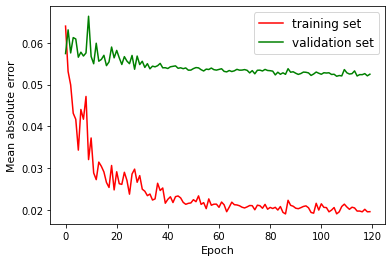

In [405]:
plt.plot(neural_model_history.history['mae'], color='r', )
plt.plot(neural_model_history.history['val_mae'], color='g')


plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)


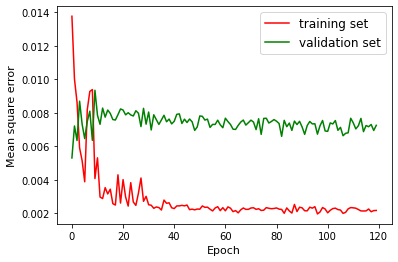

In [406]:
plt.plot(neural_model_history.history['mse'], color='r', )
plt.plot(neural_model_history.history['val_mse'], color='g')


plt.ylabel('Mean square error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)


In [407]:
ypred2 = neural_model.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy

# print("Accuracy:", metrics.accuracy_score(y_test, ypred2))

1/1 [==============================] - 0s 44ms/step
Traning and Testing on raw data, all features 



In [408]:
#zor and yor are the original velues for z and [Hz, err]
x_test_or = xscaler.inverse_transform(X_test)
# yor = scalery.inverse_transform(y)


In [409]:
x_test_sort = np.sort(x_test_or.T, axis = 1)
x_test_sort.T

array([[1.12201845e+10],
       [1.25892541e+10],
       [1.99526231e+10],
       [2.23872114e+10],
       [3.54813389e+10],
       [6.30957344e+10],
       [6.30957344e+11],
       [7.94328235e+11],
       [1.77827941e+12],
       [2.23872114e+12],
       [3.16227766e+12],
       [3.98107171e+12],
       [4.46683592e+12],
       [7.94328235e+12],
       [1.41253754e+13],
       [2.23872114e+13],
       [3.54813389e+13],
       [1.41253754e+14],
       [3.54813389e+14],
       [6.30957344e+14]])

In [410]:
lcdm = pd.read_csv('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/lcdm_counts.dat')
#lcdm = pd.read_csv('/home/jazhiel/Escritorio/YT_ensayo/Rockstar/LCDM/lcdm_counts.dat')
#df.drop(['B', 'C'], axis=1)
lcdm = lcdm.drop(['Unnamed: 0'], axis = 1)
lcdm

,log_10(M200c),counts,n(>M)
0,10.572196,773,0.028888
1,10.877562,717,0.022704
2,11.182927,689,0.016968
3,11.488293,625,0.011456
4,11.793659,372,0.006456
5,12.099025,221,0.003480
6,12.404391,107,0.001712
7,12.709756,46,0.000856
8,13.015122,35,0.000488
9,13.320488,12,0.000208


In [411]:
ypred2_sort = -np.sort(-ypred2.T, axis = -1)
ypred2_sort.T

array([[ 0.0118127 ],
       [ 0.01181095],
       [ 0.01180154],
       [ 0.01179842],
       [ 0.01178168],
       [ 0.01174636],
       [ 0.01102023],
       [ 0.01081132],
       [ 0.00952624],
       [ 0.00892224],
       [ 0.00767939],
       [ 0.00658234],
       [ 0.00604809],
       [ 0.00279929],
       [-0.00029147],
       [-0.0007595 ],
       [-0.00078762],
       [-0.00078801],
       [-0.00079306],
       [-0.00100362]], dtype=float32)

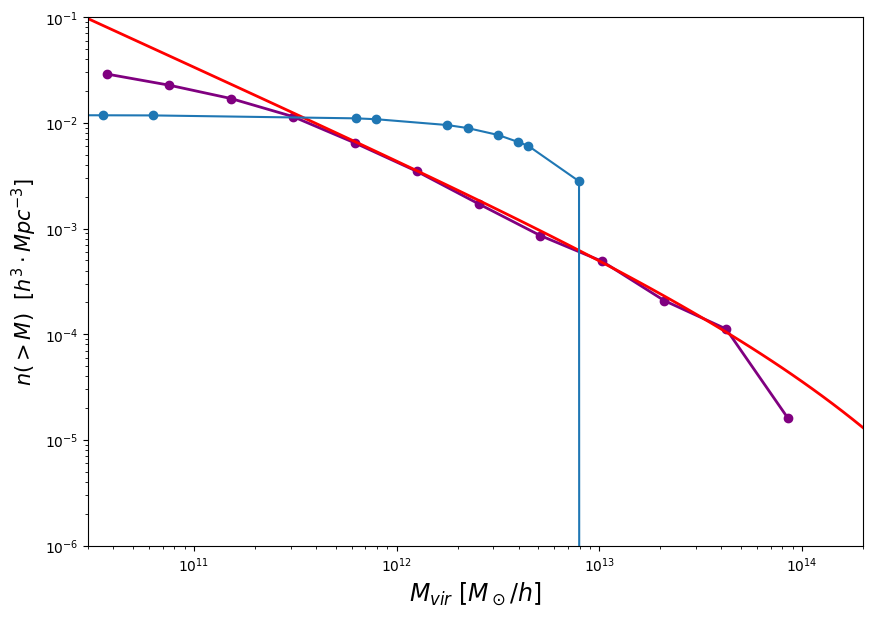

In [412]:


plt.figure(figsize=(10, 7), dpi=100)

plt.yscale('log')
plt.xscale('log')

plt.scatter(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple')
#plt.plot(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple', linestyle = '--', linewidth = 2, label = '$\Lambda$CDM simulation')
plt.plot(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple', linewidth=2, label='$\Lambda$CDM simulation')


#planck = np.loadtxt('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/all_plots/mVector_PLANCK-SMT .txt')
#plt.plot(planck[:,0], planck[:,8], 'g', label='Tinker (2008)', linewidth=2)

profile = np.loadtxt('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/all_plots/mVector_SIMULATION .txt')
plt.plot(profile[:,0],profile[:,8],'r',label='Press-Schechter (1974) ',linewidth=2)
#plt.legend(loc=0, prop={'size': 14})

plt.scatter(x_test_sort.T,ypred2_sort.T)
plt.plot(x_test_sort.T,ypred2_sort.T)
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,1])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,1])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,2])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,2])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,3])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,3])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,4])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,4])


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

plt.xlim([3.e10,2.e14])
plt.ylim([1.e-6,1.e-1])
#plt.savefig('/home/jazhiel/Escritorio/Maestria/Machine_Learning/IMG_Tesis/HMF_SFDM_extended.png')
plt.show()

In [401]:
x_test_sort.shape

(1, 20)

In [ ]:
ypred2_sort.shape